## 사기탐지(Fraud Detection System, FDS)

사기는 금융부문이 직면하는 가장 중대한 문제로, 많은 비용을 야기 한다. 연구에 따르면 일반 조직은 사기로 인해 연간 수익의 5%를 잃는것으로 추정된다.
머신러닝 기반 모델이 거래 데이터셋을 스캔하고 비정상적인 활동을 탐지하여 사기 가능성이 있는 모든 사례를 식별할 수 있으므로 사기탐지는 본질적으로 머신러닝에 적합한 작업이다. 



### 사기탐지 아키텍처

FDS 구성요소는 크게 정보수집, 이상거래 분석, 대응으로 구성된다. 

* 로그 수집 시스템은 실시간 거래정보를 수집하고 대용량 데이터를 정제하여 이상거래 분석 시스템에 전달한다.   


* 이상거래 분석 시스템은 로그 수집에서 전달받은 데이터와 고객정보, 외부정보를 종합적으로 판단하여 거래이상여부를 판단한다.  


* 대응시스템은 이상거래 분석 시스템이 이상거래라고 판단한 거래에 대해 유형별 대응 시나리오에 따라 사용자 접속차단, 담당자에게 확인 알람 등의 자동화된 시스템 조치를 수행한다.   


* 인공지능 탐지 모델은 새로이 발견된 거래패턴에 대한 내용을 학습하여 성능을 개선하여 이상거래 분석 시스템에 수시로 반영시킨다.

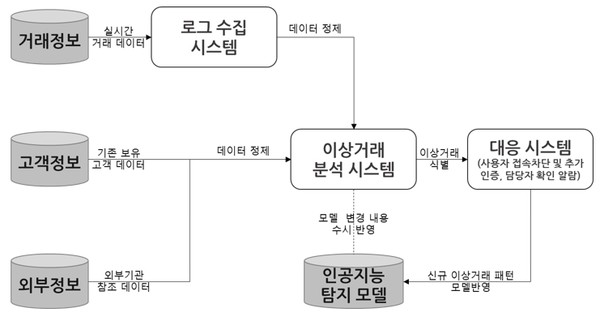



### FDS 분석 방법

> 오용탐지 기법
오용탐지 기법은 기존 이상거래 또는 사기거래에서 나타나는 주요 특징들을 조건화, 규칙화(Rule) 하여 새로이 발생하는 금융거래에 다중 조건(Multi Rule-Based)을 적용하여 필터링하는 방식으로 이상거래 여부를 식별하는 것으로 이해할 수 있다. 이 방식은 빠르고 단순한 구조지만, 새로운 패턴에 대응이 어렵다는 단점이 있다.

> 이상탐지 기법
이상탐지 기법은 RDBMS에 저장된 고객 기본 정보, 거래 정보 등의 속성(Attribute) 정보를 바탕으로 모델링하여 특이점을 탐지하는 것으로 이해할 수 있다. 이 방식은 복잡한 구조의 데이터를 종합적으로 판단하는 것으로, 발견하기 어려운 이상거래 및 사기거래를 찾아내지만, 실시간으로 처리하기에는 고성능 시스템이 요구된다는 단점이 있다.

## 문제 정의 

* 정의된 분류 프레임워크에서 목표변수의 열 이름은 **'Class'** 이며 열의 값은 사기의 경우 1, 그렇지 않으면 0이다. 
* 데이터셋의 경우 2013년 9월 이틀동안 발생한 유럽카드 소지자의 거래내역 데이터. 
* 개인정보 보호를 위해 데이터셋이 익명으로 처리되어 있기 때문에 시각화 및 특정 중요도는 모델의 동작에 대한 통찰력을 많이 제공하지 못함


#### 주요 목표
* 데이터를 다운/업 샘플링해 불균형 데이터를 처리한다.
* 거짓부정(사기 거래가 발견되지 않은 경우)를 줄이는 것이므로 올바른 평가 메트릭을 선택

### 패키지 불러오기 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')

from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler

In [2]:
# 모델 평가 분류 모델을 패키지 

from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

# Linear Discriminant Analysis,선형판별분석 , 축소 방법중의 하나 
# 데이터의 Target값 클래스끼리 최대한 분리할 수 있는 축을 찾는다. 
# 투영 후 두 클래스 간 분산은 최대한 크게 가져가고, 클래스 내부의 분산은 최대한 작게 가져가는 방식
# 클래스 간 분산이 최대가 된다는 것은 각 클래스의 중심(평균)이 서로 멀어지도록 분류한다는 것
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

# 엑스트라 트리는 포레스트 트리의 각 후보 특성을 무작위로 분할하는 식으로 무작위성을 증가시킨것
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# 딥러닝 모델 패키지 

from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 

# Loss Function을 계산할 때, 전체 데이터(Batch) 대신 일부 데이터의 모음(Mini-Batch)를 사용하여 Loss Function을 계산
from tensorflow.keras.optimizers import SGD # Stochastic Gradient Desenct

### 데이터 불러오기 

In [4]:
dataset = pd.read_csv('data/creditcard.csv')
df = dataset.copy()
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### EDA

In [5]:
df.shape

(284807, 31)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [7]:
# 기술 통계 

df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,...,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,...,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


In [7]:
# 사기 거래수 확인 

class_name = {0 : 'Not Fraud', 1 : 'Fraud'}
print(df.Class.value_counts().rename(index = class_name))

Not Fraud    284315
Fraud           492
Name: Class, dtype: int64


**데이터 레이블의 불균형이 극심하다. 대부분의 거래가 사기가 아니기 때문이다.** 

데이터셋을 모델링의 기반으로 사용하면 대부분의 모델은 사기신호에는 큰 가중치를 두지 않는다. 

비사기 데이터 포인트는 사기 신호가 제공하는 모든 가중치를 제거한다. 따라서 사기 예측을 모델링하는데 어려움을 겪을 수 있으며, 이러한 불균형으로 모델은 모든 거래가 사기가 아니라고 가정하게 되는, 받아들일 수 없는 결과를 도출. 이를 해결해야 함 

### 데이터 시작화

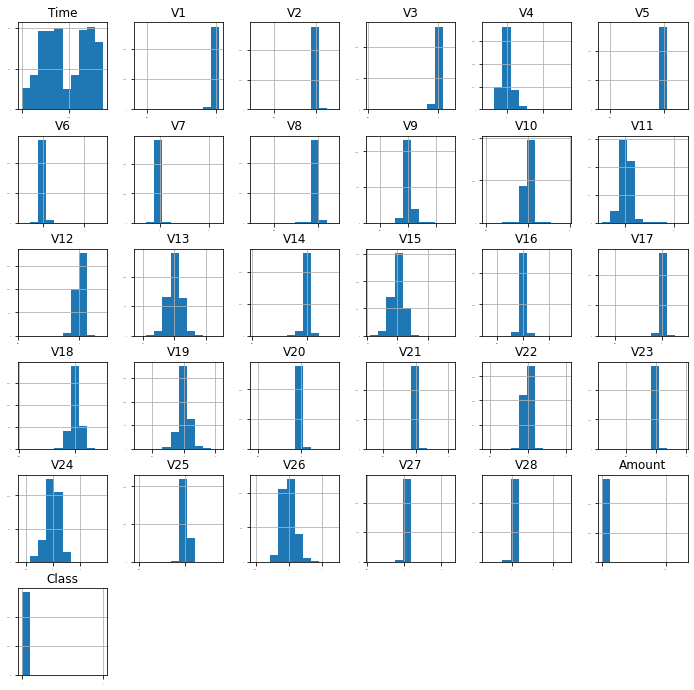

In [8]:
# histograms
df.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
plt.show()

변수명을 알 수 없고 분포가 왜도가 있음으로 히스토그램을 통해 많은 정보들 얻기 힘들다.

### 데이터 준비

In [9]:
print('Null Values =',df.isnull().values.any())

Null Values = False


### 피쳐 선택 

In [10]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest( k=10)
bestfeatures
y = dataset["Class"]
X = dataset.loc[:, dataset.columns != 'Class']
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)

featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  
print(featureScores.nlargest(10,'Score'))  

   Specs         Score
17   V17  33979.168593
14   V14  28695.547788
12   V12  20749.822361
10   V10  14057.979985
16   V16  11443.349428
3     V3  11014.508305
7     V7  10349.605408
11   V11   6999.355047
4     V4   5163.832114
18   V18   3584.380605


## 모델 평가

### 데스트 분할 및 평가 메트릭 

In [11]:
y = df['Class']
X = df.loc[:, df.columns != 'Class']

validataion_size = 0.2
seed = 7

X_train, X_test , y_train, y_test = train_test_split(X, y , test_size= validataion_size,random_state= seed)

### 모델확인 

In [12]:
# 분류 옵션 테스트 
# 모델의 다양한 하이퍼파라미터를 최적화 하기 위해 10-겹 교차검증 사용 

num_folds = 10
scoring = 'accuracy'

In [13]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
#models.append(('NB', GaussianNB()))
#models.append(('SVM', SVC()))

In [15]:
# Neural Network
#models.append(('NN', MLPClassifier()))

#Ensable Models 
#Boosting methods
#models.append(('AB', AdaBoostClassifier()))
#models.append(('GBM', GradientBoostingClassifier()))

#Bagging methods
#models.append(('RF', RandomForestClassifier()))
#models.append(('ET', ExtraTreesClassifier()))

In [14]:
# 알고리즘은 기본 튜닝 매개변수를 사용
# 알고리즘 정확도, 평균과 표준편차 확인 

results = []
names = []

for name, model in models :
    kfold = KFold(n_splits= num_folds , random_state= seed , shuffle= True)
    cv_results = cross_val_score(model , X_train, y_train , cv = kfold , scoring= scoring)
    
    results.append(cv_results)
    names.append(name)
    
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.998903 (0.000096)
LDA: 0.999350 (0.000149)
KNN: 0.998332 (0.000310)
CART: 0.999166 (0.000187)


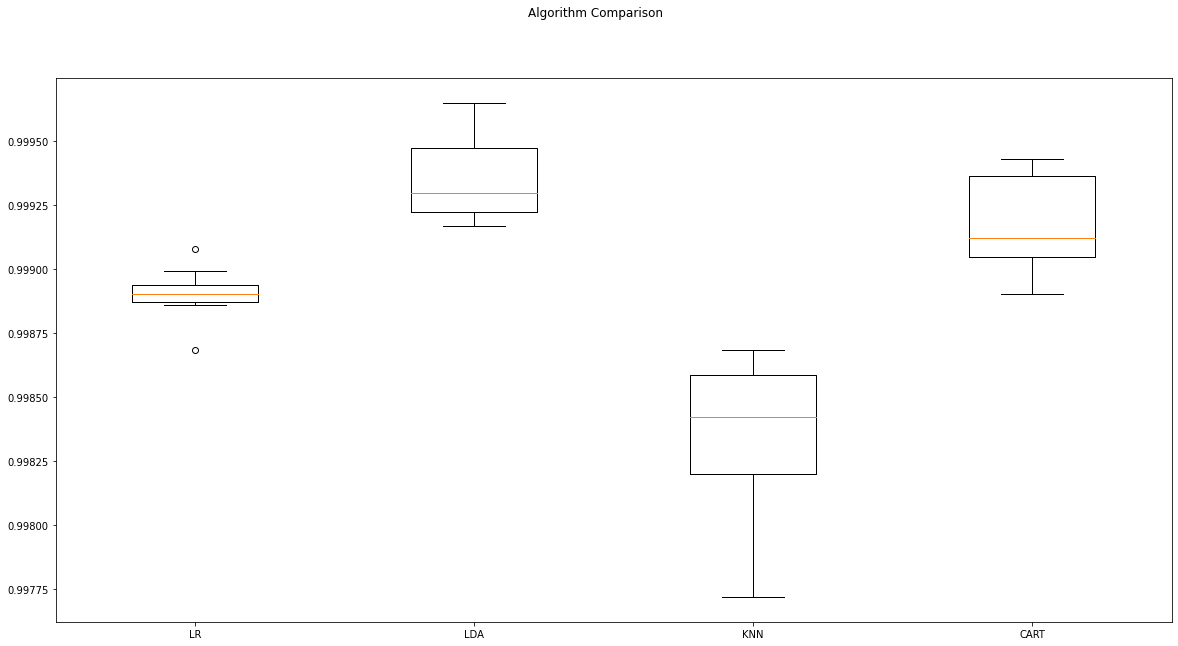

In [15]:
# 알고리즘 비교 

fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(20,10)
plt.show()

In [16]:
# 모델 준비
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# 검증셋에 대한 정확도 추정 

pred = model.predict(X_test)
print(accuracy_score(y_test , pred))
print(classification_report(y_test , pred))

0.9992275552122467
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56862
           1       0.77      0.79      0.78       100

    accuracy                           1.00     56962
   macro avg       0.89      0.89      0.89     56962
weighted avg       1.00      1.00      1.00     56962



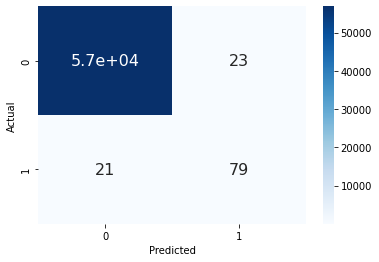

In [17]:
# 혼동 행렬 

df_cm = pd.DataFrame(confusion_matrix(y_test , pred),columns= np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

sns.heatmap(df_cm , cmap = 'Blues' , annot = True, annot_kws= {'size': 16})
plt.show()

높은 정확도 수준에도 100건중 21건이 누락되어 비사기(거짓음성)로 잘못 예측 되었다. 

* 정확도 : 모든 예측의 비율로 만들어진 정확한 예측의 수
* 정밀도 : 모델에서 양성으로 식별된 총 항목 중 양성으로 올바르게 식별된 항목의 수 
* 재현율 : 총 양성 중 양성으로 올라르게 식별된 총 항목 수

이 유형의 문제에서는 참 양성과 거짓음성의 합에 대한 참 양성 비율인 재현율에 초점을 맞춰야함 

## 모델 튜닝   

불균현한 데이터셋으로 인해 모델성능이 저하되었으므로 이점에 집중.   
올바른 평가 측정 항목을 선택했을 때의 영향을 분석, 튜닝되고 잡힌 샘플을 사용할때의 영향을 확인 

### 올바른 평가 메트릭을 선택한 모델 튜닝 

In [18]:
scoring = 'recall'

In [19]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

In [20]:
# 재현율로 결과 평가 

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.632013 (0.056489)
LDA: 0.754710 (0.046704)
KNN: 0.033329 (0.028641)
CART: 0.761048 (0.041322)


    재현율이 가장높은 CART 모델을 사용해 테스트셋 평가 
    책에서는 LDA에 사용

In [21]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

DecisionTreeClassifier()

In [22]:
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))

0.9992451107756047


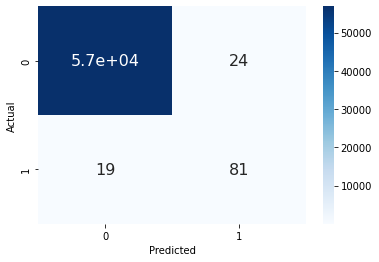

In [23]:
df_cm = pd.DataFrame(confusion_matrix(y_test , pred),columns= np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'

sns.heatmap(df_cm , cmap = 'Blues' , annot = True, annot_kws= {'size': 16})
plt.show()

### 모델 튜닝 - 무작위 언더샘플링으로 샘플 균형 잡기

현재 데이터는 '사기'라는 레이블이 붙은 데이터 포인트가 거의 없는 심각한 클래스 불균형을 보여준다. 클래스 불균형 문제는 다수 클래스에 대한 심각한 편향을 초래해 분류성능을 저하시키고 거짓 음성을 증가 시킬 수 있다. **이러한 상황을 다루는 방법 중 하나는 언더샘플링하는 것이다.**. 


### 언더샘플링과 오버샘플링 

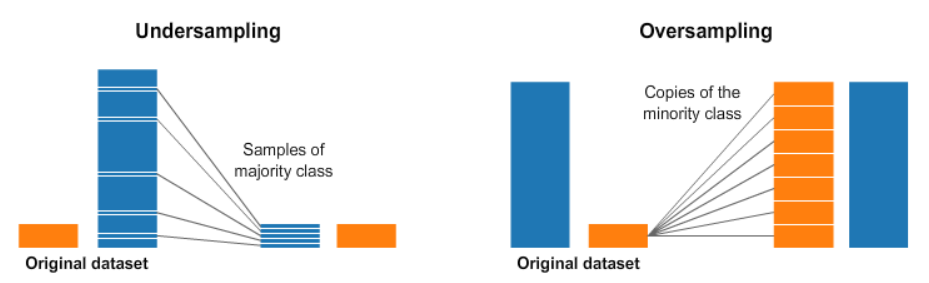

> 언더 샘플링은 불균형한 데이터 셋에서 높은 비율을 차지하던 클래스의 데이터 수를 줄임으로써 데이터 불균형을 해소하는 방법
  하지만 이 방법은 학습에 사용되는 전체 데이터 수를 급격하게 감소시켜 오히려 성능이 떨어질 수 있다.
  
> 오버 샘플링은 낮은 비율 클래스의 데이터 수를 늘림으로써 데이터 불균형을 해소하는 방법
이 방법이 가능하다면 언더 샘플링보다 훨씬 좋은 해결책이 될 수 있을것 같은데, 문제는 "어떻게" 없던 데이터를 생성하느냐 이다. 





#### SMOTE 개념
>대표적인 방법으로 소개할 개념은  SMOTE(Synthetic Minority Over-sampling Technique) 입니다.
 SMOTE 는 낮은 비율 클래스 데이터들의 최근접 이웃을 이용하여 새로운 데이터를 생성합니다.
 완전히 똑같은 특성을 가진 데이터를 복사하는 것은 의미가 없기 때문에,  
 그림과 같이 근접해 있는 데이터들과 일정한 거리를 떨어진 위치에 데이터를 생성하는 것입니다.

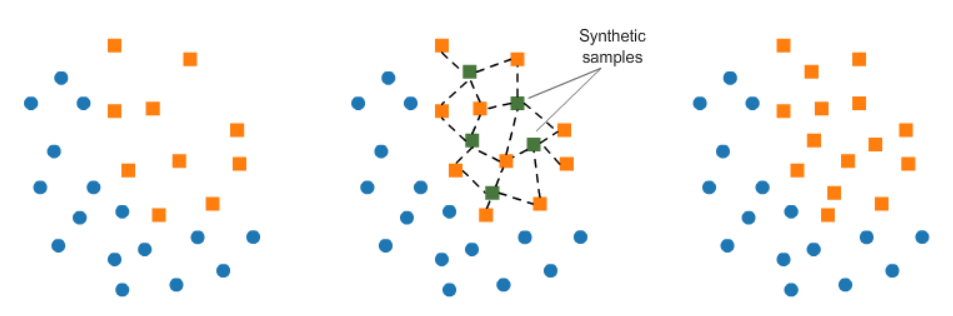




 

> 오버 샘플링을 고려할때 주의할 점 
재현율과 정밀도이다.   
양성 데이터가 음성 데이터보다 훨씬 부족한 데이터로 예를 들었을때,
오버 샘플링을 하게 되면 양성으로 예측하는 비율이 높아지기 때문에 정밀도가 감소 된다. (반대로 재현율은 증가하게 된다).
따라서 정밀도의 감소율을 낮추고 재현율의 증가율은 높이는 방법에 유의하며 SMOTE 패키지를 사용해야 한다. 

참조 : https://hwi-doc.tistory.com/entry/%EC%96%B8%EB%8D%94-%EC%83%98%ED%94%8C%EB%A7%81Undersampling%EA%B3%BC-%EC%98%A4%EB%B2%84-%EC%83%98%ED%94%8C%EB%A7%81Oversampling

### 언더 샘플링 구현 단계

 - 클래스 열에서 value_counts()를 사용해 클래스 불균형의 심각도를 확인, 사기 거래로 간주되는 사례가 어느 정도인지 확인  
 
 
 - 사기 거래량 만큼 비사기 거래량을 가져온다. 50/50 비율을 원한다고 가정하면 이는 169건의 사기와 169건의 비사기 거래가 된다.  
 
 
 - 50/50 클래스 비율의 데이터 프레임 서브 샘플이 되었다. 이 서브 샘플에서 모델을 훈련한다. 그런 다음 이 과정을 반복 수행해 훈련 샘플에 있는 비사기 관측치를 섞는다. 

In [24]:
y_train.head()

44828     0
221877    0
278826    0
149792    0
226041    0
Name: Class, dtype: int64

In [25]:
df = pd.concat([X_train, y_train] , axis = 1)

# 169행의 사기 등급 
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]
normal_distributed_df = pd.concat([fraud_df , non_fraud_df])

# 데이터프레임 행 셔플 
df_new  = normal_distributed_df.sample(frac = 1 , random_state= 42)

# 검증 데이터셋 분할 
y_train_new = df_new['Class']
x_train_new = df_new.loc[: , dataset.columns != 'Class']

Distribution of the Classes in the subsample dataset
0    0.556561
1    0.443439
Name: Class, dtype: float64


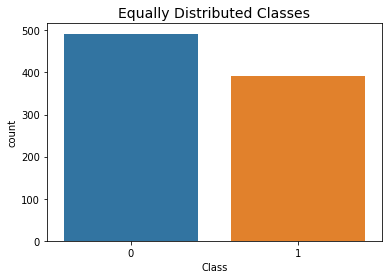

In [26]:
print('Distribution of the Classes in the subsample dataset')
print(df_new['Class'].value_counts()/len(df_new))
sns.countplot('Class', data=df_new)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

In [27]:
scoring='accuracy'

In [28]:
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Neural Network
models.append(('NN', MLPClassifier()))

#Ensable Models 
#Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

#Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

In [29]:
# 딥러닝 모델 구현 

# 케라스 분류기에 필요한 모델 생성 함수 

EnableDLModelsFlag = 1
if EnableDLModelsFlag == 1 :   
    def create_model (nerons =12 , activation = 'relu', learning_rate = 0.01, momentum = 0) :
        
        # 모델생성 
        model = Sequential()
        model.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], activation = activation))
        model.add(Dense(32, activation = activation))
        model.add(Dense(1 , activation = 'sigmoid'))
    
        # 모델 컴파일 
        optimizer = SGD(lr=learning_rate, momentum=momentum)
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
        return model    
    
    models.append(('DNN', KerasClassifier(build_fn=create_model, epochs=50, batch_size=10, verbose=0)))

In [30]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, x_train_new, y_train_new, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: 0.935483 (0.020987)
LDA: 0.912858 (0.024971)
KNN: 0.644944 (0.043277)
CART: 0.906141 (0.026623)
NB: 0.876762 (0.027601)
SVM: 0.597383 (0.034344)
NN: 0.609755 (0.137597)
AB: 0.924196 (0.027717)
GBM: 0.937794 (0.025915)
RF: 0.942314 (0.023392)
ET: 0.940015 (0.022194)
DNN: 0.767952 (0.146925)


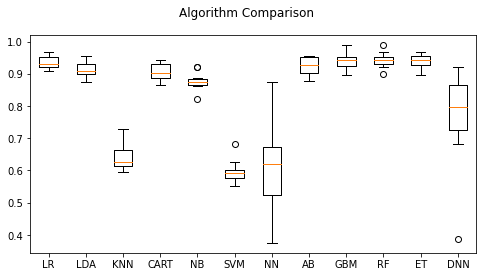

In [31]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
plt.show()

In [32]:
# Grid Search: GradientBoosting Tuning
'''
n_estimators : int (default=100)
    The number of boosting stages to perform. 
    Gradient boosting is fairly robust to over-fitting so a large number usually results in better performance.
max_depth : integer, optional (default=3)
    maximum depth of the individual regression estimators. 
    The maximum depth limits the number of nodes in the tree. 
    Tune this parameter for best performance; the best value depends on the interaction of the input variables.

''' 

# 격자 부스팅 조절 
n_estimators = [20,180,1000]
max_depth= [2, 3,5]
param_grid = dict(n_estimators=n_estimators, max_depth=max_depth)
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(x_train_new, y_train_new)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.945723 using {'max_depth': 5, 'n_estimators': 1000}
#7 0.933248 (0.017893) with: {'max_depth': 2, 'n_estimators': 20}
#3 0.942288 (0.023501) with: {'max_depth': 2, 'n_estimators': 180}
#5 0.940079 (0.021982) with: {'max_depth': 2, 'n_estimators': 1000}
#8 0.928741 (0.020234) with: {'max_depth': 3, 'n_estimators': 20}
#6 0.940041 (0.025360) with: {'max_depth': 3, 'n_estimators': 180}
#2 0.943437 (0.022050) with: {'max_depth': 3, 'n_estimators': 1000}
#9 0.926468 (0.025924) with: {'max_depth': 5, 'n_estimators': 20}
#4 0.941203 (0.025662) with: {'max_depth': 5, 'n_estimators': 180}
#1 0.945723 (0.023003) with: {'max_depth': 5, 'n_estimators': 1000}


In [33]:
model = GradientBoostingClassifier(max_depth= 5, n_estimators = 1000)
model.fit(x_train_new, y_train_new)

GradientBoostingClassifier(max_depth=5, n_estimators=1000)

In [34]:
# 예측
pred = model.predict(X_test)
print(accuracy_score(y_test, pred))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

0.9766686562971806
[[55542  1320]
 [    9    91]]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56862
           1       0.06      0.91      0.12       100

    accuracy                           0.98     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.98      0.99     56962



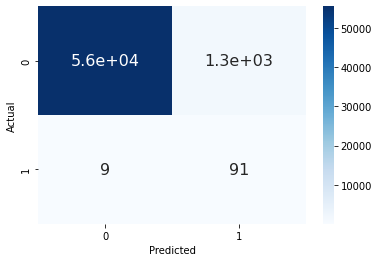

In [35]:
df_cm = pd.DataFrame(confusion_matrix(y_test, pred), columns=np.unique(y_test), index = np.unique(y_test))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True,annot_kws={"size": 16})# font size
plt.show()